In [3]:
# My code
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pyslsa

# System Libs
from importlib import reload
import pickle
import glob
import os

# Scientific Libs
import numpy as np
from scipy.optimize import brentq
import tqdm

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# Set some parameters
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)
reload(pyslsa)

/home/brad/.conda/envs/neuraltda-3-test/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<module 'pyslsa' from '/home/brad/.conda/envs/neuraltda-3-test/lib/python3.6/site-packages/pyslsa.cpython-36m-x86_64-linux-gnu.so'>

In [4]:
# Do Model Fitting with C code

nsamples2 = 10

def binmat_to_scg_C_old(sptrain):
    
    # turn a binmat to a C scg
    scg = pyslsa.SCG()
    msimps = sc.binarytomaxsimplex(binMat=sptrain, rDup=True)
    for msimp in msimps:
        t = pyslsa.Simplex()
        for vert in msimp:
            t.add_vertex(vert)
        scg.add_max_simplex(t)
    return scg

def binmat_to_scg_C(sptrain):
    msimps = sc.binarytomaxsimplex(sptrain, True)
    return pyslsa.build_SCG(msimps)
    
def precompute_test_scg(tests):
    Emodels = []
    for ind in range(nsamples2):
        Emodels.append(binmat_to_scg_C(tests[:, :, ind]))
    
    return Emodels

def loss_C(a, beta, dim):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    #Emodels = precompute_test_scg(binMatsamples)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        maxsimps = sc.binarytomaxsimplex(binMatsamples[:, :, ind], rDup=True)
        # Compute SCG for test spike trains
        #Emodel = Emodels[ind]
        Emodel = pyslsa.build_SCG(maxsimps)

        # Compute KL divergence for this test spike train and store it. 
        #%time div = pyslsa.KL(Etarget, Emodel, dim, beta)
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_C_precomp(ind, beta):
    KLsave=[]
    Emodels = Emodels_p[ind]
    for ind2 in range(nsamples2):
        
        # Compute SCG for test spike trains
        Emodel = Emodels[ind2]

        # Compute KL divergence for this test spike train and store it. 
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def KL_python(Etarg, Emodel, d, beta):


    #Ddata = sc.boundaryOperatorMatrix(Edata, d)
    #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
    Lsamp = sc.compute_laplacian(Emodel, d)
    Ldata = sc.compute_laplacian(Etarg, d)
    if (np.size(Lsamp) > np.size(Ldata)):
        (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
    else:
        (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
    #rsamp = sc.densityMatrix(Lsamp, beta)

    #rdata = sc.densityMatrix(Ldata, beta)
    #print(Ldata)
    #print(rsamp)
    #print(rdata)

    #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
    #JSsave.append(sc.JSdivergence(rdata, rsamp))
    return sc.KLdivergence_lap(Ldata, Lsamp, beta)

In [5]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.07
probs = (a*np.ones((ncells, 1)))
nsamples = 2
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

In [6]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    E = binmat_to_scg_C(binMatsamples[:, :, ind])
    SCGs.append(E)
Etarget = SCGs[0]
Etest = SCGs[1]

SCGs_old = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs_old.append(E)
Etarget_old = SCGs_old[0]
Etest_old = SCGs_old[1]

In [10]:
est_save = []
ntrials = 1
X = np.linspace(0.0005, 0.08, 100)

beta = -0.65
beta2 = -0.15
dim = 2

for t in range(ntrials):
    #print(t)
    KL=[]
    KL2 = []
    JS = []
    KLerr = []
    KLerr2 = []
    JSerr = []
    for i, x in tqdm.tqdm(enumerate(X)):
        #print(x)
        (m, stderr) = loss_C(x, beta, dim)
        #(mb2, stderrb2) = loss_C(x, beta2, dim)
        KL.append(m)
        KLerr.append(stderr)
        
        #KL2.append(mb2)
        #KLerr2.append(stderrb2)
        

100it [00:34,  1.32it/s]


RuntimeError: xdata and ydata must be the same length

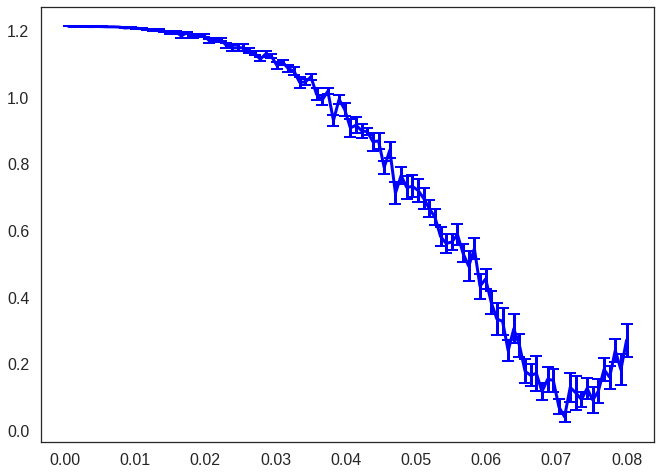

In [11]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.errorbar(X, KL2, yerr=KLerr2, linewidth=3, capsize=6, capthick=2, fmt='g')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')

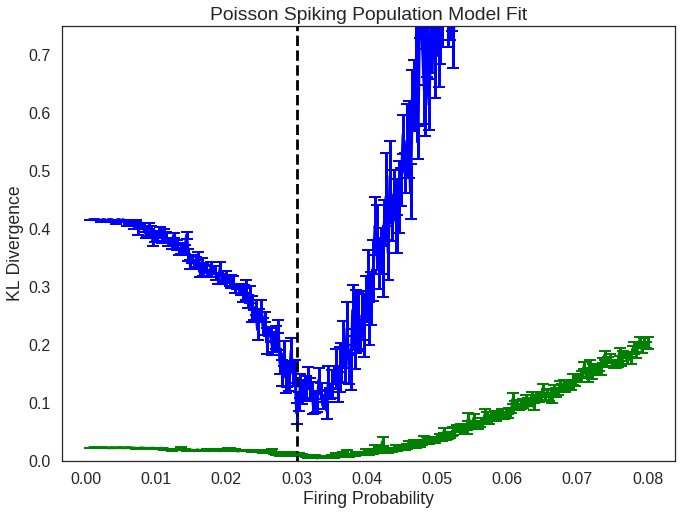

In [15]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.errorbar(X, KL2, yerr=KLerr2, linewidth=3, capsize=6, capthick=2, fmt='g')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')

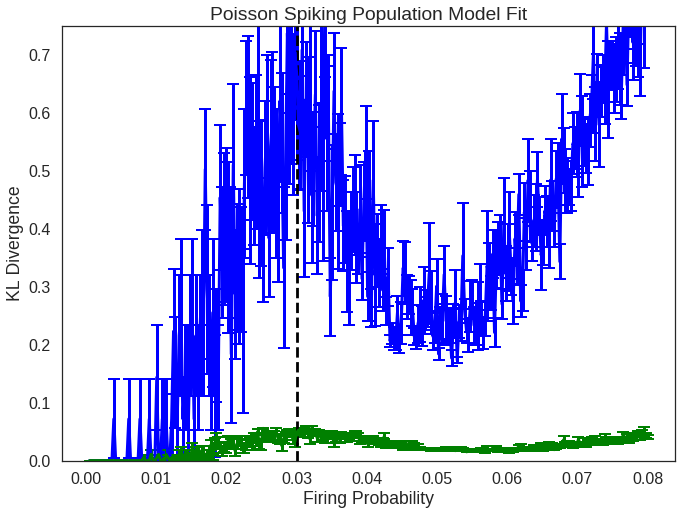

In [21]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.errorbar(X, KL2, yerr=KLerr2, linewidth=3, capsize=6, capthick=2, fmt='g')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')

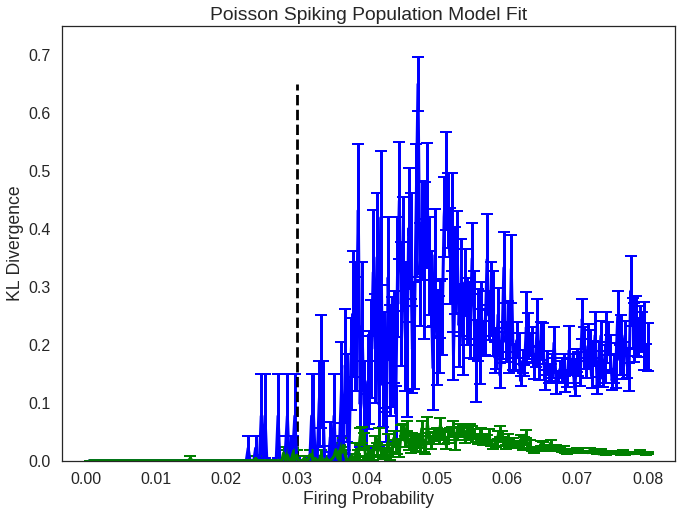

In [6]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.errorbar(X, KL2, yerr=KLerr2, linewidth=3, capsize=6, capthick=2, fmt='g')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')